In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

%load_ext tensorboard

_include_('curriculum_vqa')
_include_('commons')

data_bin = f'{DEV_HOME}/curriculum_vqa/data-bin'

In [3]:
from cvqa import datasets, models, trainers, viz

In [27]:
# curriculum_root = f'{data_bin}/basic_curriculum'
curriculum_root = f'{data_bin}/curriculum_1'

train_dataset = datasets.Curriculum(curriculum_root, 'train', limit=100)
vocab = train_dataset.vocab
dev_dataset = datasets.Curriculum(curriculum_root, 'dev', vocab=vocab, limit=100)
train_dataset

Root: /Users/urisherman/Work/workspace/curriculum_vqa/data-bin/curriculum_1/train 
Samples: 100 (N_prompt=11, N_target=1)
Concepts: 0 
Classes: 0 
Vocab Tokens:50

In [32]:
train_dataset.use_viz_rep = True
dev_dataset.use_viz_rep = True

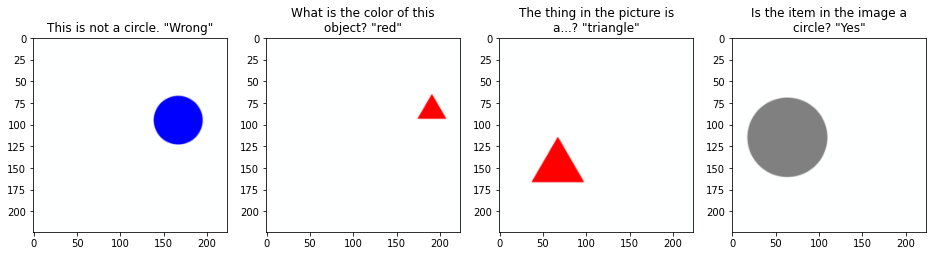

In [33]:
viz.show_samples(train_dataset)

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
from cvqa import fairseq_misc

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

vocab = train_dataset.vocab

def build_model(
    d=128,
    img_output_features=4,
    encoder_ffn_dim=256,
    encoder_layers=2,
    encoder_attention_heads=2,
    decoder_ffn_dim=256,
    decoder_layers=2,
    decoder_attention_heads=2):

    tokens_embed = fairseq_misc.build_embedding(vocab, d)
    encoder = fairseq_misc.build_vqa_encoder(
        vocab, tokens_embed,
        ffn_dim=encoder_ffn_dim,
        layers=encoder_layers,
        attention_heads = encoder_attention_heads
    )
    decoder = fairseq_misc.build_decoder(
        vocab, tokens_embed,
        ffn_dim=decoder_ffn_dim,
        layers=decoder_layers,
        attention_heads=decoder_attention_heads
    )

    struct_viz=True
    if struct_viz:
        img_perceptor = models.StructuredImageModel(
          train_dataset.struct_viz_vocab, d, img_output_features)
    else:
        img_perceptor = models.BasicImgModel(d, img_output_features)
    
    return models.VQAModelV1(encoder, img_perceptor, decoder, bos=vocab.bos_index)
    

trainer = trainers.VQATrainer(progressbar='epochs')

def train_model(model, lr=1e-4, epochs=10, batch_size=32):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss, train_acc, dev_acc = trainer.train(
        model, train_dataset, dev_dataset, 
        optimizer, num_epochs=epochs, batch_size=batch_size
    )
    return {
        'train_loss': train_loss, 
        'train_acc': train_acc, 
        'dev_acc': dev_acc
    }

In [48]:
model = build_model(    
    d=16,
    img_output_features=2,
    encoder_ffn_dim=32,
    encoder_layers=2,
    encoder_attention_heads=2,
    decoder_ffn_dim=32,
    decoder_layers=1,
    decoder_attention_heads=1
)

train_metrics = train_model(model, lr=9e-3, epochs=200)

[epoch=199, steps=6371, train_acc=0.42, dev_acc=0.30] loss: 0.914: 100%|██████████| 200/200 [00:15<00:00, 12.93it/s]


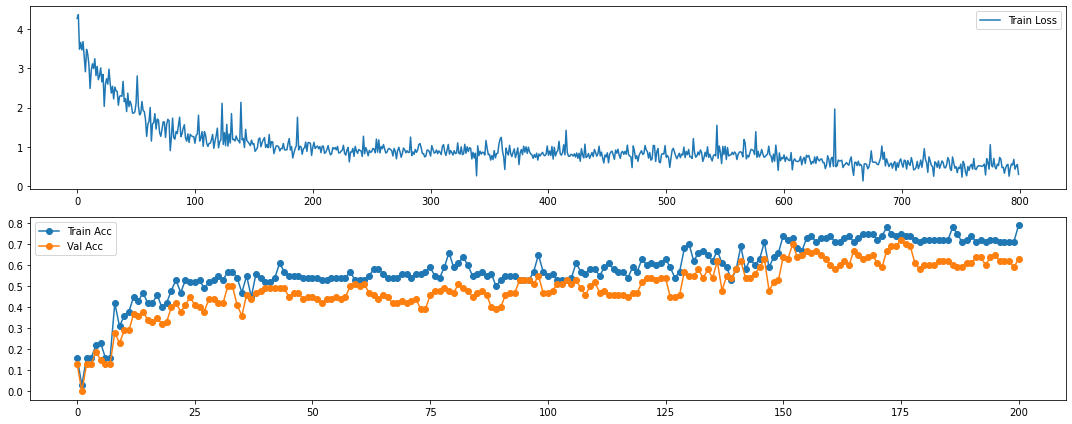

In [47]:
viz.plot_training(**train_metrics)

Sample index: 12
Prompt: What is the color of this object?
Decoded encoded prompt: What is the color of this object? <pad> <pad> <pad>
True: red
Pred: red
* Encoded Structured Img Rep: tensor([6, 5])


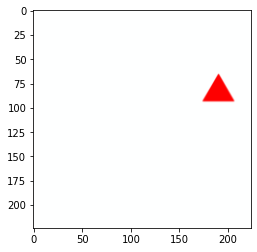

In [42]:
viz.test_natural_sample(model, train_dataset)

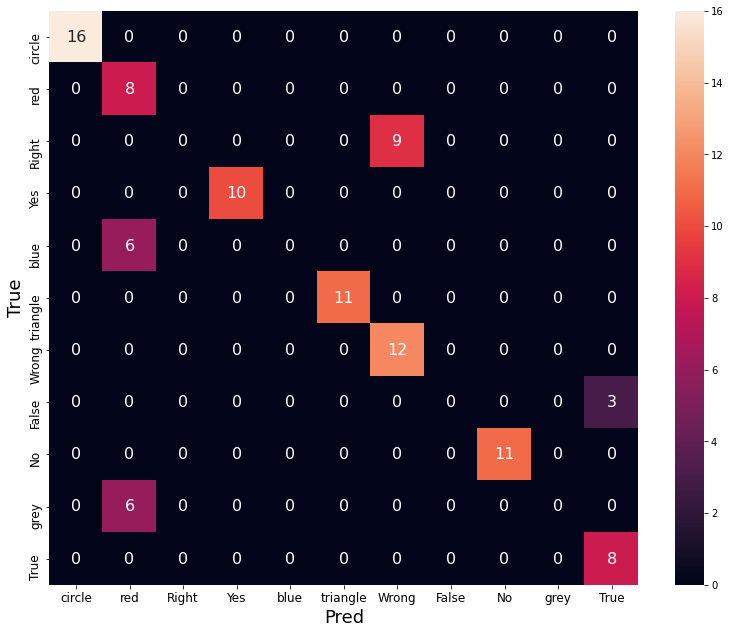

In [43]:
y_true, y_pred = trainer.get_predictions(model, train_dataset)
viz.one_word_conf_mat(y_true, y_pred, train_dataset.vocab)

In [12]:
from cvqa.experiments import Experiments


exp = Experiments(build_model, train_model)

exp.execute({
    'd': [16, 32, 64, 128],
    'img_output_features': np.arange(2, 7),
    'encoder_ffn_dim': [16, 32, 64, 128],
    'encoder_layers': np.arange(1, 4),
    'encoder_attention_heads': np.arange(1, 4),
    'decoder_ffn_dim': [16, 32, 64, 128],
    'decoder_layers': np.arange(1, 4),
    'decoder_attention_heads': np.arange(1, 4),
    'epochs': [20]
}, limit=100)

In [15]:
results = Experiments.load_results('experiments/run--09-24--18-39-27')